## Imports

In [5]:
import numpy as np
import scipy as scp
import pandas as pd
#import spectrum as spec
import math
import time
from matplotlib import pyplot as plt

## Prepare raw_data.csv-File
used so for testing the data doesn't need to be fetched from grafana.

In [6]:
data_df = pd.read_csv("data/2024-03-10_testset_filtered.csv")
data_df["ticks"] = data_df["ticks"] / 1000 + time.time()
data_df["time"] = pd.to_datetime(data_df['ticks'],unit='s')
del data_df["ticks"]
# set index. important!
data_df = data_df.set_index("time")

#### add the "magnitude" columns combining x/y/z

In [7]:
data_df["xyzH"] = np.sqrt(data_df["xH"] ** 2 + data_df["yH"] ** 2 + data_df["zH"] ** 2)
data_df["xyzL"] = np.sqrt(data_df["xL"] ** 2 + data_df["yL"] ** 2 + data_df["zL"] ** 2)

#### compensate the data-aquisition-jitter (by upsampling and interpolation)

Alternative: Use nearest-neighbour or spline-interpolation instead of linear one?

In [8]:
# method=linear = ignores the index and treats them as equally spaced. not suitable for usecase, use method=time!
data_df = data_df.resample("0.001s").mean().interpolate(method='time')

# optional: downsample again to e.g. 50Hz used in HAR-Dataset?

## remove noise and split into "body" and "gravitation"-branches

In [9]:
# define butterworth filter
def bworth_filter(data, f_sample, order, f_corner, btype="low"):
    cutoff = f_corner / (0.5 * f_sample)
    b, a = scp.signal.butter(order, cutoff, btype=btype, analog=False)

    return scp.signal.filtfilt(b, a, data)

# apply filter to all columns
body_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 20))

gravity_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 0.3))

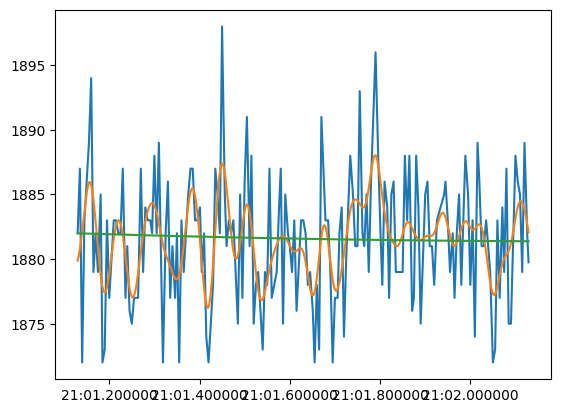

In [10]:
plt.plot(data_df.index[100:1100], data_df["xH"][100:1100])
plt.plot(body_df.index[100:1100], body_df["xH"][100:1100])
plt.plot(gravity_df.index[100:1100], gravity_df["xH"][100:1100])

In [11]:
#baseline_df = pd.merge_asof(body_df, gravity_df, left_index=True, right_index=True, direction="nearest", suffixes=("_body", "_gravity"))
baseline_df = pd.merge(body_df, gravity_df, left_index=True, right_index=True, how="outer", suffixes=("_body", "_gravity"))

In [12]:
# derivate "acceleration to jerk" 
derivative_df = baseline_df.apply(lambda col: np.gradient(col, edge_order=2))

In [13]:
intermediate_df = pd.merge(baseline_df, derivative_df, left_index=True, right_index=True, how="outer", suffixes=("_accel", "_jerk"))

## Sampling/Batching for statistical feature generation

In [70]:
## sample by time duration
TIME_DURATION = "0.5s"

intermediate_df["time_tmp"] = intermediate_df.index
intermediate_df['window_label'] = intermediate_df["time_tmp"].apply(lambda ts: ts.floor(TIME_DURATION))


In [15]:
## sample by count
BATCH_SIZE = 128
intermediate_df['window_label'] = np.arange(len(intermediate_df)) // BATCH_SIZE

### process the groups one after another

In [41]:
output_data = []

In [71]:
grouped_df = intermediate_df.groupby('window_label')

In [60]:
print("unique=", intermediate_df["window_label"].nunique())


oversampling_timedelta = 0.001
chunkoverlap = 0.5
chunksize = 500

unique= 30


In [37]:
#grouped_df = intermediate_df.groupby('window_label').apply(lambda x: x.shift(periods=-(int(len(x) * chunkoverlap)-1))).dropna()

In [67]:

print(samplect, window_count)
#intermediate_df.shape[0] / 
#for group_id in range(
intermediate_df.shape[0]

500.0 60


14881

In [68]:
intermediate_df[0:500]

,xH_body_accel,yH_body_accel,zH_body_accel,xL_body_accel,yL_body_accel,zL_body_accel,magni_body_accel,temp_body_accel,xyzH_body_accel,xyzL_body_accel,...,zH_gravity_jerk,xL_gravity_jerk,yL_gravity_jerk,zL_gravity_jerk,magni_gravity_jerk,temp_gravity_jerk,xyzH_gravity_jerk,xyzL_gravity_jerk,time_tmp,window_label
time,,,,,,,,,,,,,,,,,,,,,
2024-03-29 05:21:01.030,1882.054390,1884.001929,1879.934203,-547.095468,466.868137,10060.956838,443.016838,338.413017,3259.715234,10086.614068,...,0.002523,0.052820,0.087763,0.007333,-0.000163,-0.011421,0.001014,0.009896,2024-03-29 05:21:01.030,2024-03-29 05:21:01.000
2024-03-29 05:21:01.031,1881.968064,1883.991129,1880.072922,-545.114700,468.848486,10062.904672,442.992313,339.710271,3259.739477,10088.572353,...,0.002524,0.052813,0.087764,0.007320,-0.000160,-0.011428,0.001014,0.009884,2024-03-29 05:21:01.031,2024-03-29 05:21:01.000
2024-03-29 05:21:01.032,1881.879973,1883.980356,1880.214443,-543.089865,470.873468,10064.891818,442.967277,341.031752,3259.764339,10090.570249,...,0.002524,0.052806,0.087765,0.007308,-0.000158,-0.011435,0.001015,0.009872,2024-03-29 05:21:01.032,2024-03-29 05:21:01.000
2024-03-29 05:21:01.033,1881.790332,1883.969646,1880.358381,-541.026158,472.937960,10066.913073,442.941791,342.373782,3259.789743,10092.602531,...,0.002525,0.052800,0.087765,0.007296,-0.000155,-0.011441,0.001015,0.009860,2024-03-29 05:21:01.033,2024-03-29 05:21:01.000
2024-03-29 05:21:01.034,1881.699347,1883.959034,1880.504356,-538.928707,475.036908,10068.963383,442.915908,343.732790,3259.815607,10094.664121,...,0.002525,0.052793,0.087766,0.007283,-0.000152,-0.011448,0.001016,0.009848,2024-03-29 05:21:01.034,2024-03-29 05:21:01.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29 05:21:01.525,1878.958590,1884.286622,1880.666092,-474.931328,599.091242,10061.173098,440.709675,298.886679,3258.526629,10091.192458,...,0.002446,0.039859,0.069988,-0.000202,0.001627,-0.011905,0.001158,0.001949,2024-03-29 05:21:01.525,2024-03-29 05:21:01.500
2024-03-29 05:21:01.526,1878.642488,1884.395667,1880.515529,-472.449315,599.150428,10061.263766,440.748479,299.423022,3258.320079,10091.127779,...,0.002445,0.039819,0.069922,-0.000218,0.001631,-0.011900,0.001158,0.001932,2024-03-29 05:21:01.526,2024-03-29 05:21:01.500
2024-03-29 05:21:01.527,1878.346060,1884.495495,1880.372069,-469.739525,598.510047,10061.424617,440.786188,299.972514,3258.123669,10091.085485,...,0.002445,0.039779,0.069855,-0.000234,0.001635,-0.011896,0.001158,0.001914,2024-03-29 05:21:01.527,2024-03-29 05:21:01.500


In [66]:
for group_id in range(window_count):
    start_idx = group_id * (samplect * (1-chunkoverlap))
    end_idx = start_idx + samplect
    print(start_idx, end_idx)

0.0 500.0
250.0 750.0
500.0 1000.0
750.0 1250.0
1000.0 1500.0
1250.0 1750.0
1500.0 2000.0
1750.0 2250.0
2000.0 2500.0
2250.0 2750.0
2500.0 3000.0
2750.0 3250.0
3000.0 3500.0
3250.0 3750.0
3500.0 4000.0
3750.0 4250.0
4000.0 4500.0
4250.0 4750.0
4500.0 5000.0
4750.0 5250.0
5000.0 5500.0
5250.0 5750.0
5500.0 6000.0
5750.0 6250.0
6000.0 6500.0
6250.0 6750.0
6500.0 7000.0
6750.0 7250.0
7000.0 7500.0
7250.0 7750.0
7500.0 8000.0
7750.0 8250.0
8000.0 8500.0
8250.0 8750.0
8500.0 9000.0
8750.0 9250.0
9000.0 9500.0
9250.0 9750.0
9500.0 10000.0
9750.0 10250.0
10000.0 10500.0
10250.0 10750.0
10500.0 11000.0
10750.0 11250.0
11000.0 11500.0
11250.0 11750.0
11500.0 12000.0
11750.0 12250.0
12000.0 12500.0
12250.0 12750.0
12500.0 13000.0
12750.0 13250.0
13000.0 13500.0
13250.0 13750.0
13500.0 14000.0
13750.0 14250.0
14000.0 14500.0
14250.0 14750.0
14500.0 15000.0
14750.0 15250.0


In [73]:
group_ct = 0
for window_label, group in grouped_df:
    
    break
group

,xH_body_accel,yH_body_accel,zH_body_accel,xL_body_accel,yL_body_accel,zL_body_accel,magni_body_accel,temp_body_accel,xyzH_body_accel,xyzL_body_accel,...,zH_gravity_jerk,xL_gravity_jerk,yL_gravity_jerk,zL_gravity_jerk,magni_gravity_jerk,temp_gravity_jerk,xyzH_gravity_jerk,xyzL_gravity_jerk,time_tmp,window_label
time,,,,,,,,,,,,,,,,,,,,,
2024-03-29 05:21:01.030,1882.054390,1884.001929,1879.934203,-547.095468,466.868137,10060.956838,443.016838,338.413017,3259.715234,10086.614068,...,0.002523,0.052820,0.087763,0.007333,-0.000163,-0.011421,0.001014,0.009896,2024-03-29 05:21:01.030,2024-03-29 05:21:01
2024-03-29 05:21:01.031,1881.968064,1883.991129,1880.072922,-545.114700,468.848486,10062.904672,442.992313,339.710271,3259.739477,10088.572353,...,0.002524,0.052813,0.087764,0.007320,-0.000160,-0.011428,0.001014,0.009884,2024-03-29 05:21:01.031,2024-03-29 05:21:01
2024-03-29 05:21:01.032,1881.879973,1883.980356,1880.214443,-543.089865,470.873468,10064.891818,442.967277,341.031752,3259.764339,10090.570249,...,0.002524,0.052806,0.087765,0.007308,-0.000158,-0.011435,0.001015,0.009872,2024-03-29 05:21:01.032,2024-03-29 05:21:01
2024-03-29 05:21:01.033,1881.790332,1883.969646,1880.358381,-541.026158,472.937960,10066.913073,442.941791,342.373782,3259.789743,10092.602531,...,0.002525,0.052800,0.087765,0.007296,-0.000155,-0.011441,0.001015,0.009860,2024-03-29 05:21:01.033,2024-03-29 05:21:01
2024-03-29 05:21:01.034,1881.699347,1883.959034,1880.504356,-538.928707,475.036908,10068.963383,442.915908,343.732790,3259.815607,10094.664121,...,0.002525,0.052793,0.087766,0.007283,-0.000152,-0.011448,0.001016,0.009848,2024-03-29 05:21:01.034,2024-03-29 05:21:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29 05:21:01.495,1882.565487,1883.950716,1883.761399,-423.409319,476.029157,10089.792829,441.914400,304.324271,3262.202463,10111.211078,...,0.002469,0.041045,0.071944,0.000272,0.001501,-0.012034,0.001156,0.002480,2024-03-29 05:21:01.495,2024-03-29 05:21:01
2024-03-29 05:21:01.496,1882.826873,1883.896556,1883.729451,-423.324635,474.093010,10089.223476,441.808945,303.742612,3262.303910,10110.545514,...,0.002469,0.041006,0.071880,0.000256,0.001505,-0.012030,0.001156,0.002462,2024-03-29 05:21:01.496,2024-03-29 05:21:01
2024-03-29 05:21:01.497,1883.077806,1883.839330,1883.699347,-423.711250,473.038789,10088.528899,441.705592,303.131402,3262.398605,10109.824398,...,0.002468,0.040967,0.071816,0.000240,0.001509,-0.012026,0.001157,0.002444,2024-03-29 05:21:01.497,2024-03-29 05:21:01


In [77]:
intermediate_df[0:500]

,xH_body_accel,yH_body_accel,zH_body_accel,xL_body_accel,yL_body_accel,zL_body_accel,magni_body_accel,temp_body_accel,xyzH_body_accel,xyzL_body_accel,...,zH_gravity_jerk,xL_gravity_jerk,yL_gravity_jerk,zL_gravity_jerk,magni_gravity_jerk,temp_gravity_jerk,xyzH_gravity_jerk,xyzL_gravity_jerk,time_tmp,window_label
time,,,,,,,,,,,,,,,,,,,,,
2024-03-29 05:21:01.030,1882.054390,1884.001929,1879.934203,-547.095468,466.868137,10060.956838,443.016838,338.413017,3259.715234,10086.614068,...,0.002523,0.052820,0.087763,0.007333,-0.000163,-0.011421,0.001014,0.009896,2024-03-29 05:21:01.030,2024-03-29 05:21:01.000
2024-03-29 05:21:01.031,1881.968064,1883.991129,1880.072922,-545.114700,468.848486,10062.904672,442.992313,339.710271,3259.739477,10088.572353,...,0.002524,0.052813,0.087764,0.007320,-0.000160,-0.011428,0.001014,0.009884,2024-03-29 05:21:01.031,2024-03-29 05:21:01.000
2024-03-29 05:21:01.032,1881.879973,1883.980356,1880.214443,-543.089865,470.873468,10064.891818,442.967277,341.031752,3259.764339,10090.570249,...,0.002524,0.052806,0.087765,0.007308,-0.000158,-0.011435,0.001015,0.009872,2024-03-29 05:21:01.032,2024-03-29 05:21:01.000
2024-03-29 05:21:01.033,1881.790332,1883.969646,1880.358381,-541.026158,472.937960,10066.913073,442.941791,342.373782,3259.789743,10092.602531,...,0.002525,0.052800,0.087765,0.007296,-0.000155,-0.011441,0.001015,0.009860,2024-03-29 05:21:01.033,2024-03-29 05:21:01.000
2024-03-29 05:21:01.034,1881.699347,1883.959034,1880.504356,-538.928707,475.036908,10068.963383,442.915908,343.732790,3259.815607,10094.664121,...,0.002525,0.052793,0.087766,0.007283,-0.000152,-0.011448,0.001016,0.009848,2024-03-29 05:21:01.034,2024-03-29 05:21:01.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29 05:21:01.525,1878.958590,1884.286622,1880.666092,-474.931328,599.091242,10061.173098,440.709675,298.886679,3258.526629,10091.192458,...,0.002446,0.039859,0.069988,-0.000202,0.001627,-0.011905,0.001158,0.001949,2024-03-29 05:21:01.525,2024-03-29 05:21:01.500
2024-03-29 05:21:01.526,1878.642488,1884.395667,1880.515529,-472.449315,599.150428,10061.263766,440.748479,299.423022,3258.320079,10091.127779,...,0.002445,0.039819,0.069922,-0.000218,0.001631,-0.011900,0.001158,0.001932,2024-03-29 05:21:01.526,2024-03-29 05:21:01.500
2024-03-29 05:21:01.527,1878.346060,1884.495495,1880.372069,-469.739525,598.510047,10061.424617,440.786188,299.972514,3258.123669,10091.085485,...,0.002445,0.039779,0.069855,-0.000234,0.001635,-0.011896,0.001158,0.001914,2024-03-29 05:21:01.527,2024-03-29 05:21:01.500


In [53]:


for window_label, group in grouped_df:
    del group["time_tmp"]
    del group["window_label"]
    timestamps = list(group.index.map(lambda _: _.timestamp()))
    
    # add basic metrics
    v_mean = group.mean().add_suffix("_Tmean")
    v_std = group.std().add_suffix("_Tstd")
    v_mad = group.apply(lambda col: scp.stats.median_abs_deviation(col.values)).add_suffix("_Tmad")
    v_min = group.min().add_suffix("_Tmin")
    v_max = group.max().add_suffix("_Tmax")
    v_sma = group.apply(lambda col: scp.integrate.simpson(y=np.abs(col.values), x=timestamps)).add_suffix("_Tsma")
    v_iqr = group.apply(lambda col: np.subtract(*np.percentile(col.values, [75, 25]))).add_suffix("_Tiqr")
    v_entropy = group.apply(lambda col: scp.stats.entropy(col.values)).add_suffix("_Tentropy")
    v_energy = group.apply(lambda col: np.average(np.power(col.values, 2))).add_suffix("_Tenergy")


    # add AR-coefficients https://pyspectrum.readthedocs.io/en/latest/ref_param.html#spectrum.burg.arburg
    #arburg_order = 4
    #for n in range(arburg_order):
    #column_list.append()
    #arburg = group.apply(lambda col: spec.arburg(np.fabs(col.values), 4)[0]).add_suffix(f"_Tarburg_coeff")
        #column_list.append(group.apply(lambda col: spec.arburg(col.values, arburg_order)[0].real[n]).add_suffix(f"_Tar_coeff_{n}"))

    # add Frequency Space information
    #def apply_fft(col, band_count=8):
    v_fft_list = []
    fft_band_count = 8
    for col_name in group:
        col = group[col_name]
        bands_data = scp.fft.fft(col.values)
        energy_spectrum = np.abs(bands_data[:len(bands_data)//2])**2
        band_width = math.ceil(len(bands_data) / (fft_band_count * 2))
        bands_energy = {}
        for i in range(fft_band_count):
            if i == 0: # ignore the DC-Part of FFT
                s_idx = 1
            else:
                s_idx = i * band_width
            e_idx = min(len(energy_spectrum), (i+1)*band_width)
            subband_energy = np.sum(energy_spectrum[s_idx:e_idx])
            bands_energy[col.name + f"_FenergyBand_{i}"] = subband_energy
        v_fft_list.append(pd.Series(bands_energy))
    v_fft = pd.concat(v_fft_list)

    # add to the output table
    combi = pd.concat([v_mean, v_std, v_mad, v_min, v_max, v_sma, v_iqr, v_entropy, v_energy, v_fft], axis=0)
    
    output_data.append(combi)

In [54]:
output_data

[xH_body_accel_Tmean                1880.130045
 yH_body_accel_Tmean                1885.344388
 zH_body_accel_Tmean                1884.004647
 xL_body_accel_Tmean                -465.117817
 yL_body_accel_Tmean                 548.775746
                                       ...     
 xyzL_gravity_jerk_FenergyBand_3       0.000019
 xyzL_gravity_jerk_FenergyBand_4       0.000013
 xyzL_gravity_jerk_FenergyBand_5       0.000010
 xyzL_gravity_jerk_FenergyBand_6       0.000008
 xyzL_gravity_jerk_FenergyBand_7       0.000005
 Length: 680, dtype: float64,
 xH_body_accel_Tmean                1880.854269
 yH_body_accel_Tmean                1884.210768
 zH_body_accel_Tmean                1880.781258
 xL_body_accel_Tmean                -476.982843
 yL_body_accel_Tmean                 581.313564
                                       ...     
 xyzL_gravity_jerk_FenergyBand_3       0.001423
 xyzL_gravity_jerk_FenergyBand_4       0.000953
 xyzL_gravity_jerk_FenergyBand_5       0.000734
 xyzL_grav

In [75]:
spec.arburg(np.abs(group.values), 4)[0].real

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [55]:
final_data = pd.DataFrame(output_data)
final_data

,xH_body_accel_Tmean,yH_body_accel_Tmean,zH_body_accel_Tmean,xL_body_accel_Tmean,yL_body_accel_Tmean,zL_body_accel_Tmean,magni_body_accel_Tmean,temp_body_accel_Tmean,xyzH_body_accel_Tmean,xyzL_body_accel_Tmean,...,xyzH_gravity_jerk_FenergyBand_6,xyzH_gravity_jerk_FenergyBand_7,xyzL_gravity_jerk_FenergyBand_0,xyzL_gravity_jerk_FenergyBand_1,xyzL_gravity_jerk_FenergyBand_2,xyzL_gravity_jerk_FenergyBand_3,xyzL_gravity_jerk_FenergyBand_4,xyzL_gravity_jerk_FenergyBand_5,xyzL_gravity_jerk_FenergyBand_6,xyzL_gravity_jerk_FenergyBand_7
0,1880.130045,1885.344388,1884.004647,-465.117817,548.775746,10102.445560,441.195764,353.883261,3261.739071,10128.688896,...,1.041178e-08,6.539413e-09,2.608579e-03,1.053074e-04,3.574248e-05,1.918318e-05,1.282889e-05,9.885075e-06,8.479884e-06,5.326047e-06
1,1880.854269,1884.210768,1880.781258,-476.982843,581.313564,10048.586471,441.551725,301.070422,3259.645560,10077.767925,...,4.328754e-08,3.289742e-08,7.649496e-01,7.552183e-03,2.630018e-03,1.422772e-03,9.534491e-04,7.337073e-04,6.269226e-04,4.764455e-04
2,1882.021933,1884.774075,1883.174661,-500.220789,594.660033,10058.796112,443.091299,303.617985,3262.023113,10089.858472,...,1.798381e-07,1.366724e-07,3.565073e-01,3.475092e-03,1.210178e-03,6.546742e-04,4.387198e-04,3.376078e-04,2.884719e-04,2.192314e-04
3,1881.131052,1883.899226,1882.069911,-486.019018,574.011066,10033.162665,445.658633,303.124239,3260.364366,10062.299021,...,6.643609e-07,5.048978e-07,7.708949e-03,2.023666e-05,7.036172e-06,3.805079e-06,2.549587e-06,1.961866e-06,1.676286e-06,1.273921e-06
4,1881.566099,1885.374590,1884.080419,-482.293839,566.865498,10035.712942,448.539649,305.334237,3262.630260,10064.374719,...,2.846991e-06,2.163642e-06,3.767392e-02,3.243451e-04,1.129427e-04,6.109798e-05,4.094362e-05,3.150723e-05,2.692159e-05,2.045972e-05
5,1881.597929,1885.361615,1883.417639,-473.058766,568.294857,10054.768620,450.271737,302.866515,3262.257626,10082.753701,...,4.831961e-06,3.672170e-06,7.166314e-02,6.463838e-04,2.250894e-04,1.217663e-04,8.159950e-05,6.279311e-05,5.365407e-05,4.077574e-05
6,1881.486041,1884.827430,1883.519714,-522.538125,570.741033,10030.168805,451.320787,298.030564,3261.942372,10062.296119,...,2.592446e-06,1.970194e-06,1.025317e-01,9.928180e-04,3.457406e-04,1.870362e-04,1.253394e-04,9.645232e-05,8.241451e-05,6.263296e-05
7,1882.370052,1883.618779,1882.595127,-468.652214,563.840934,10029.930100,452.521168,303.986661,3261.221037,10059.222330,...,3.940166e-08,2.994413e-08,2.529524e-03,3.159666e-06,1.095308e-06,5.919431e-07,3.965335e-07,3.050917e-07,2.606666e-07,1.980938e-07
8,1880.427156,1883.855144,1882.900182,-479.628190,576.081081,10038.961333,452.780482,305.570294,3260.411980,10067.867084,...,2.214526e-06,1.682984e-06,2.753882e-01,2.746983e-03,9.566316e-04,5.175137e-04,3.468042e-04,2.668762e-04,2.280347e-04,1.733007e-04
9,1880.131298,1884.740142,1881.914137,-499.167672,580.356634,10017.791633,452.688404,298.899723,3260.182835,10048.095009,...,6.929726e-06,5.266418e-06,1.006386e+00,9.948963e-03,3.464690e-03,1.874308e-03,1.256040e-03,9.665596e-04,8.258853e-04,6.276522e-04


In [59]:
final_data.to_csv("final_data.csv")

In [27]:
group.values[0]

array([ 1.88205439e+03,  1.88400193e+03,  1.87993420e+03, -5.47095476e+02,
        4.66868136e+02,  1.00609568e+04,  4.43016838e+02,  3.38413013e+02,
        3.25971523e+03,  1.00866141e+04,  1.88210082e+03,  1.88440870e+03,
        1.88007023e+03, -5.25934864e+02,  5.10938863e+02,  1.00481763e+04,
        4.42308311e+02,  3.16646452e+02,  3.26006000e+03,  1.00755025e+04,
       -8.54442849e-02, -1.08133122e-02,  1.37319292e-01,  1.95876442e+00,
        1.95806274e+00,  1.92820867e+00, -2.42704110e-02,  1.28516070e+00,
        2.39340236e-02,  1.93850955e+00, -1.08098473e-03,  2.98752921e-04,
        2.52304719e-03,  5.28201388e-02,  8.77629764e-02,  7.33308337e-03,
       -1.63066869e-04, -1.14212929e-02,  1.01369777e-03,  9.89637682e-03])